# Подготовка среды

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shared drives/hse_BERT/hse_Af_Tr_BERT')

In [ ]:
!pip install transformers

In [ ]:
!pip install razdel

In [ ]:
import torch
import nltk
import re
import json
import time
import numpy as np
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.spatial.distance import cosine

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
# tokenizer.to(device)

In [ ]:
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence',
                                  output_hidden_states = True,
                                  )
# model.to(device)
model.eval()

In [ ]:
import pickle as pc

def my_dump(file, name):
    with open("./bin/" + name + ".pic", 'wb') as f:
        pc.dump(file, f)

def my_load(name):
    with open("./bin/" + name + ".pic", 'rb') as f:
        return pc.load(f)

In [ ]:
from razdel import sentenize

# short 

## generate (split) sentences

In [ ]:
with open("./texts/all_cyberleninka_liter2/all_cyberleninka_liter2.txt", 'r') as f:
    data = f.read()

In [ ]:
%%time
sent1 = list(sentenize(data))

CPU times: user 5min 54s, sys: 2.37 s, total: 5min 56s
Wall time: 5min 57s


In [ ]:
%%time
my_dump(sent1, "sent1")
# my_dump(sent2, "sent2")

CPU times: user 20.2 s, sys: 2.33 s, total: 22.5 s
Wall time: 33 s


## read sentences

In [ ]:
%%time
sent1 = my_load("sent2")

CPU times: user 9.25 s, sys: 1.86 s, total: 11.1 s
Wall time: 13.3 s


In [ ]:
def get_text_from_ST(ss):
    return ss.text

In [ ]:
sent = list(map(get_text_from_ST, sent1))

In [ ]:
len(sent)

2348859

## work

In [ ]:
for_embeddings = {
    "король", 
    "королева",
    "мужчина",
    "женьщина"
}

In [ ]:
def sum_tensors(token):
    return torch.sum(token[-4:], dim=0)

def get_embeddings(text):
    tokenized_text = tokenizer.tokenize("[CLS] " + text.lower() + " [SEP]")
    if len(tokenized_text) > 80:
        return [],[]
    marked_text = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([marked_text])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0),
                                    dim=1).permute(1,0,2)
    
    token_vecs_sum = list(map(sum_tensors, token_embeddings))
    return tokenized_text, token_vecs_sum

# token_vecs = hidden_states[-2][0]
# sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
# pr_tr = dict.fromkeys(for_embeddings)
# for i in pr_tr:
#     pr_tr[i] = []

# pr_tr

In [ ]:
# words = re.compile('\w+')
# words.fullmatch("khbkjhk")
# re.fullmatch(r'\w+', "12kb12lkjnl")

In [ ]:
# %%time
# for j in range(1):
#     for i in range(j * 100, (j + 1) * 100):
#         tt, tvs = get_embeddings(sent[i])
#         for i in range(len(tt)):
#             if tt[i].isalpha():
#                 if tt[i] in pr_tr:
#                     pr_tr[tt[i]].append(tvs[i])
#                 else:
#                     pr_tr[tt[i]] = [tvs[i]]

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(100, 150):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2:
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00100 --- time: 137.6621994972229	--- total: 137.84444999694824
done 00101 --- time: 149.5163869857788	--- total: 287.3831753730774
done 00102 --- time: 136.84836649894714	--- total: 424.2566647529602
done 00103 --- time: 130.18299460411072	--- total: 554.4581937789917
done 00104 --- time: 133.70924830436707	--- total: 688.1828598976135
done 00105 --- time: 141.20963501930237	--- total: 829.4129283428192
done 00106 --- time: 144.49995470046997	--- total: 973.9391596317291
done 00107 --- time: 148.38853669166565	--- total: 1122.349370956421
done 00108 --- time: 143.76249957084656	--- total: 1266.1394443511963
done 00109 --- time: 149.47142004966736	--- total: 1415.6334211826324
done 00110 --- time: 138.89482712745667	--- total: 1554.5492520332336
done 00111 --- time: 148.09643030166626	--- total: 1702.6658599376678
done 00112 --- time: 110.56291174888611	--- total: 1813.2554214000702
done 00113 --- time: 138.82633638381958	--- total: 1952.0848124027252
done 00114 --- time: 145.0511

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(150, 200):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2:
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00150 --- time: 139.70022130012512	--- total: 139.72060108184814
done 00151 --- time: 138.41445064544678	--- total: 278.16055130958557
done 00152 --- time: 154.06990957260132	--- total: 432.25029397010803
done 00153 --- time: 151.7927508354187	--- total: 584.0730874538422
done 00154 --- time: 147.89220929145813	--- total: 731.9980370998383
done 00155 --- time: 147.89570426940918	--- total: 879.9216935634613
done 00156 --- time: 154.43541288375854	--- total: 1034.3838546276093
done 00157 --- time: 146.5056185722351	--- total: 1180.9182107448578
done 00158 --- time: 145.9018177986145	--- total: 1326.8469576835632
done 00159 --- time: 140.14189767837524	--- total: 1467.0180807113647
done 00160 --- time: 139.27792692184448	--- total: 1606.3196322917938
done 00161 --- time: 148.8545482158661	--- total: 1755.2002720832825
done 00162 --- time: 166.55676293373108	--- total: 1921.7888314723969
done 00163 --- time: 157.1356463432312	--- total: 2078.9621002674103
done 00164 --- time: 151.987

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(950, 990):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2 :
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00950 --- time: 138.70702481269836	--- total: 138.7400608062744
done 00951 --- time: 139.73812127113342	--- total: 278.5008895397186
done 00952 --- time: 141.49968481063843	--- total: 420.0263614654541
done 00953 --- time: 145.2072718143463	--- total: 565.2585573196411
done 00954 --- time: 144.11903882026672	--- total: 709.403243303299
done 00955 --- time: 145.3424050807953	--- total: 854.7731823921204
done 00956 --- time: 133.59272718429565	--- total: 988.3913192749023
done 00957 --- time: 138.45962738990784	--- total: 1126.8738708496094
done 00958 --- time: 147.355562210083	--- total: 1274.2505238056183
done 00959 --- time: 143.65145254135132	--- total: 1417.9269483089447
done 00960 --- time: 140.92576932907104	--- total: 1558.8777866363525
done 00961 --- time: 141.36303234100342	--- total: 1700.2634229660034
done 00962 --- time: 140.90476322174072	--- total: 1841.19025349617
done 00963 --- time: 136.11500120162964	--- total: 1977.3278601169586
done 00964 --- time: 146.134373426

In [ ]:
out = list(zip(pr_tr.keys(), list(map(len, pr_tr.values()))))
out.sort(key = lambda i: i[1], reverse=True)
out

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)


In [ ]:

diff_bank = 1 - cosine(token_vecs_sum[11], token_vecs_sum[12])
print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.74


In [ ]:
?sent1[0]

## oldwork

In [ ]:
text = 'Чтобы не грусть, что вместо сети определили на пары.'
text2 = "At eight o'clock on Thursday morning. Arthur didn't feel very good."

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

In [ ]:
tokenized_text

['[CLS]',
 'чтобы',
 'не',
 'груст',
 '##ь',
 ',',
 'что',
 'вместо',
 'сети',
 'определили',
 'на',
 'пары',
 '.',
 '[SEP]']

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [ ]:
# token_i = 5
# layer_i = 5
# vec = hidden_states[layer_i][batch_i][token_i]

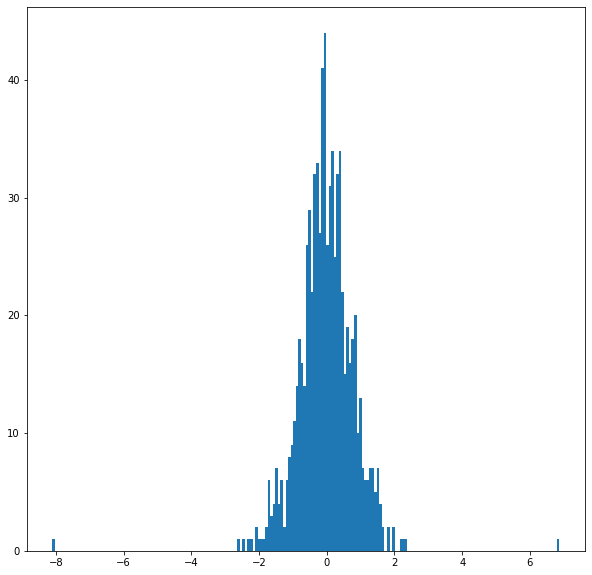

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

In [ ]:
token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 17 x 768


In [ ]:
len(token_vecs_sum)

17

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 замок
2 сто
3 ##ял
4 не
5 ##пр
6 ##ист
7 ##уп
8 ##ныи
9 .
10 замок
11 легко
12 от
13 ##крыл
14 ##ся
15 .
16 [SEP]


In [ ]:
token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
token_vecs.size()

torch.Size([17, 768])

In [ ]:
diff_bank = 1 - cosine(token_vecs_sum[1], token_vecs_sum[10])
diff_bank1 = 1 - cosine(token_vecs[1], token_vecs[10])
# same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)
# print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.92
